# Global Imports

In [1]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any
import glob
import re
from datetime import datetime

# Local Imports

In [2]:
from training.train import EpochLogs, grid_search, LogPoint
from dataset.character_dataset import CharImageDataset
from models.allcnn2d import AllCNN2D

# Globals

In [3]:
DATASET_SPLIT: float = 0.8
MODEL_NAME: str = "Alpha"

# Define Paths
Workspace

In [4]:
notebook_dir: str = os.path.abspath(".")
root_dir: str = os.path.join(
    notebook_dir,
    os.pardir,
    os.pardir
)

data_dir: str = os.path.join(
    root_dir,
    "data",
    "lambda"
)

model_save_dirpath: str = os.path.join(
    root_dir,
    "models",
    "allcnn"
)


Image paths

In [5]:

images_path_glob: str = os.path.join(
    data_dir,
    "u*.png"
)
images_path_regex: str = r"(u[0-9a-fA-F]+)-([0-9]+)\.png"

file_paths: list[str] = glob.glob(images_path_glob)


# Helper Functions

In [6]:
def get_current_time() -> str:
    return datetime.now().strftime("%Y-%m-%d-%H-%M-%S")


# Logging Setup 

In [7]:

logging_path: str = f"cnn_train_log_{get_current_time()}.csv"

with open(logging_path, "w") as f:
    f.write("TIME,TRAIN_ACC,VAL_ACC,TRAIN_LOSS,VAL_LOSS,LR\n")

def log(
    train_acc: float, 
    train_loss: float, 
    val_acc: float, 
    val_loss, 
    lr: float
)-> None:
    with open(logging_path, "a") as f:
        f.write(f"{get_current_time()},{train_acc},{val_acc},{train_loss},{val_loss},{lr}\n")

# Extract Labels

In [8]:

labeled_image_paths: list[tuple[str, str]] = []

file_path: str
for file_path in file_paths:
    match = re.search(images_path_regex, file_path)
    
    if not match:
        continue
    
    u_hexvalue: str = match.group(1)
    labeled_image_paths.append((u_hexvalue, file_path))

labels: list[str]
file_paths: list[str]
labels, file_paths =  list(zip(*labeled_image_paths))


# Load Dataset

In [9]:

split_index: int = int(len(file_paths)*DATASET_SPLIT)
all_label_classes: list[str] = list(set(labels))

train_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=file_paths[:split_index],
    labels=labels[:split_index],
    all_label_classes=all_label_classes,
    rotation_limit=0.1,
    translation_limit=0.2,
    skew_limit=0.05,
    zoom_change=0.3,
    image_dims=(64, 64)
)

val_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=file_paths[split_index:],
    labels=labels[split_index:],
    all_label_classes=all_label_classes,
    rotation_limit=0.0,
    translation_limit=0.0,
    skew_limit=0.00,
    zoom_change=0.0,
    image_dims=(64, 64)
)




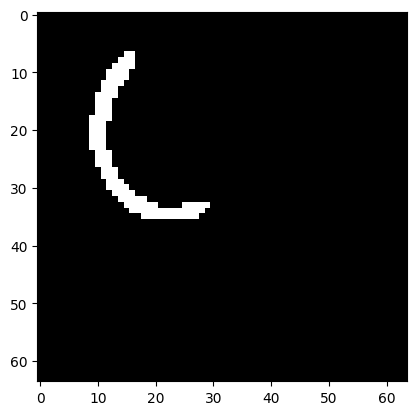

tensor([1., 0., 0., 0., 0., 0., 0.])


In [10]:
for im, lab in train_char_dataset:
    plt.imshow(rearrange(im, "1 h w -> h w")*255, cmap="gray")
    plt.show()
    print(lab)
    break

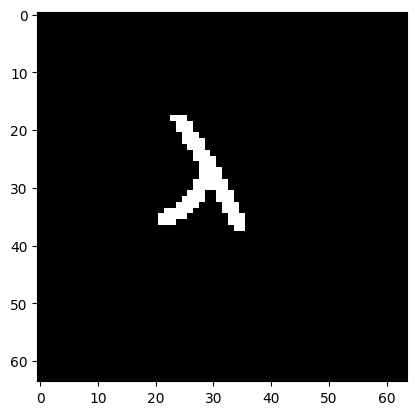

tensor([0., 0., 0., 0., 0., 1., 0.])


In [11]:
for im, lab in val_char_dataset:
    plt.imshow(rearrange(im, "1 h w -> h w")*255, cmap="gray")
    plt.show()
    print(lab)
    break

# Load DataLoader

In [12]:
train_dataloader: DataLoader = DataLoader(
    train_char_dataset,
    shuffle=True,
    batch_size=16
)

val_dataloader: DataLoader = DataLoader(
    train_char_dataset,
    shuffle=False,
    batch_size=16
)

# Define Model Hyperparameters

In [13]:

all_model_parameters: list[dict[str, Any]] = [
    {
        "conv_features": (1, 16, 32, 32, 32),
        "fully_connected_features": (32,7),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.1,
        "verbose": True,
        "name_prefix": MODEL_NAME
    }
]

all_optim_parameters: list[dict[str, Any]] = [
    {
        "lr": 0.0001,
        "weight_decay": 0.0002
    }
]


# Train

In [ ]:

for epoch in range(100):

    epoch_log: EpochLogs
    for epoch_log in grid_search(
        model_factory=AllCNN2D,
        all_model_parameters=all_model_parameters,
        optim_factory=AdamW,
        all_optim_params=all_optim_parameters,
        epochs=100,
        criterion=nn.CrossEntropyLoss(),
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        lr_decay_window_size=10,
        lr_decay_minimum=0.0,
        scheduler_scale=0.5,
        device="cuda"
    ):
        train_logpoints: list[LogPoint] = epoch_log.train_logs
        val_logpoints: list[LogPoint] = epoch_log.val_logs
        
        
        train_count: int = 0
        val_count: int = 0
        
        train_losses_tally: float = 0.0
        val_losses_tally: float = 0.0
        
        train_correct_tally: int = 0
        val_correct_tally: int = 0
        
        for log_point in train_logpoints: 
            
            y_hat_pred: torch.Tensor = torch.argmax(
                log_point.y_hat, 
                axis=-1
            ).detach().cpu()
            
            y_pred: torch.Tensor = torch.argmax(
                log_point.y, axis=-1
            ).detach().cpu()

            train_correct_tally += torch.sum(y_hat_pred==y_pred)
            
            train_losses_tally += torch.sum(log_point.loss)
            
            train_count += len(y_hat_pred)
            
        for log_point in val_logpoints: 
            
            y_hat_pred: torch.Tensor = torch.argmax(
                log_point.y_hat, 
                axis=-1
            ).detach().cpu()
            
            y_pred: torch.Tensor = torch.argmax(
                log_point.y, axis=-1
            ).detach().cpu()

            val_correct_tally += torch.sum(y_hat_pred==y_pred)
            
            val_losses_tally += torch.sum(log_point.loss)
            
            val_count += len(y_hat_pred)
            
        train_accuracy: float = train_correct_tally/train_count
        val_accuracy: float = val_correct_tally/val_count
        
        train_loss: float = train_losses_tally/train_count
        val_loss: float = val_losses_tally/val_count
        
        cur_learning_rate: float = epoch_log.optimiser.param_groups[0]["lr"]
        
        model_checkpoint_path: str = os.path.join(
            model_save_dirpath,
            f"{MODEL_NAME}_epoch{epoch_log.epoch}.pkl"
        )
        
        with open(model_checkpoint_path, "wb") as f:
            torch.save(epoch_log.model.state_dict(), f)
        
        print(f"Train Accuracy      : {train_accuracy}")
        print(f"Val Accuracy        : {val_accuracy}")
        print(f"Loss                : {train_loss}")
        print(f"Val Loss            : {val_loss}")
        print(f"Learning Rate       : {cur_learning_rate}")
        
        log(
            train_accuracy,
            train_loss,
            val_accuracy,
            val_loss,
            cur_learning_rate
        )

Layer (type:depth-idx)                   Output Shape              Param #
AllCNN2D                                 [1, 7]                    --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 64, 64]           160
│    │    └─Dropout2d: 3-2               [1, 16, 64, 64]           --
│    │    └─BatchNorm2d: 3-3             [1, 16, 64, 64]           32
│    │    └─LeakyReLU: 3-4               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-5                  [1, 16, 32, 32]           2,320
│    │    └─Dropout2d: 3-6               [1, 16, 32, 32]           --
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    │    └─LeakyReLU: 3-8               [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-9                  [1, 32, 32, 32]           4,640
│    │  

Validating Model...: 100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


Train Accuracy      : 0.11397058516740799
Val Accuracy        : 0.18014705181121826
Loss                : 0.12264765053987503
Val Loss            : 0.12296097725629807
Learning Rate       : 0.0001


Validating Model...: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Train Accuracy      : 0.16544117033481598
Val Accuracy        : 0.18014705181121826
Loss                : 0.11903635412454605
Val Loss            : 0.12162923812866211
Learning Rate       : 0.0001


Validating Model...: 100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


Train Accuracy      : 0.15441176295280457
Val Accuracy        : 0.18382352590560913
Loss                : 0.1169675663113594
Val Loss            : 0.11889785528182983
Learning Rate       : 0.0001


Validating Model...:  18%|█▊        | 3/17 [00:02<00:11,  1.27it/s]